In [1]:
tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow

In [1]:
tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [6]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [7]:
df.head()


user activity       timestamp    x-axis     y-axis    z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


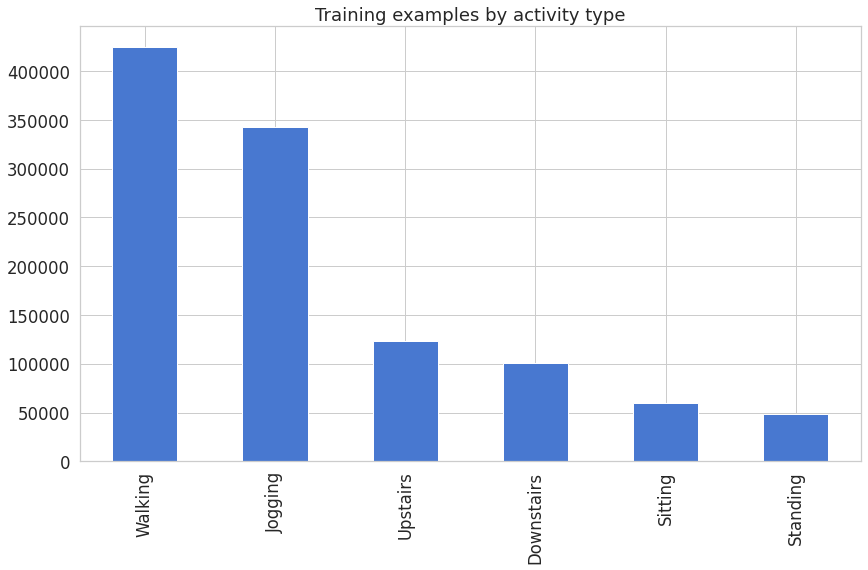

In [9]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');


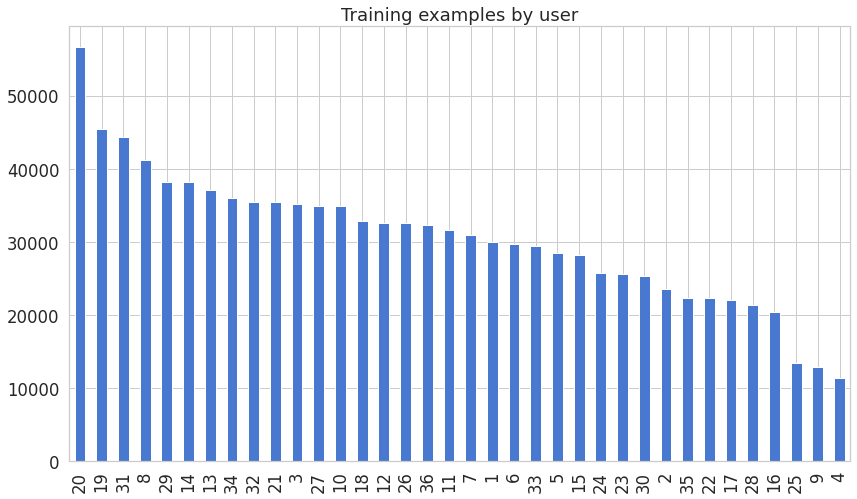

In [10]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');


In [11]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

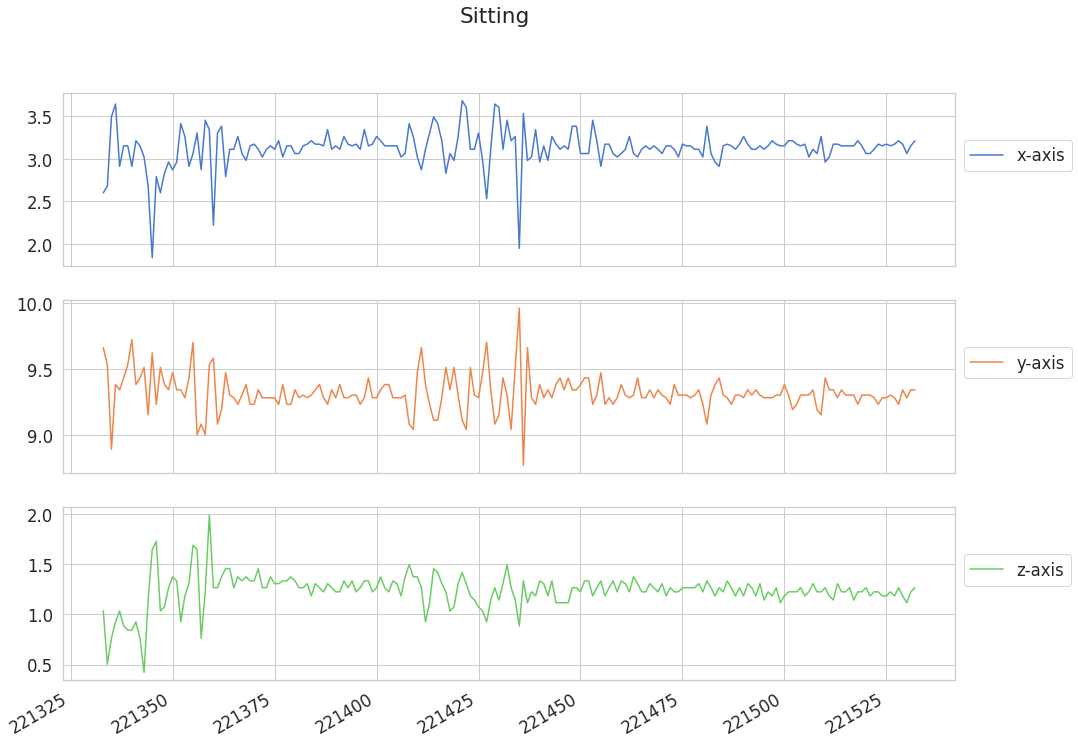

In [12]:
plot_activity("Sitting", df)

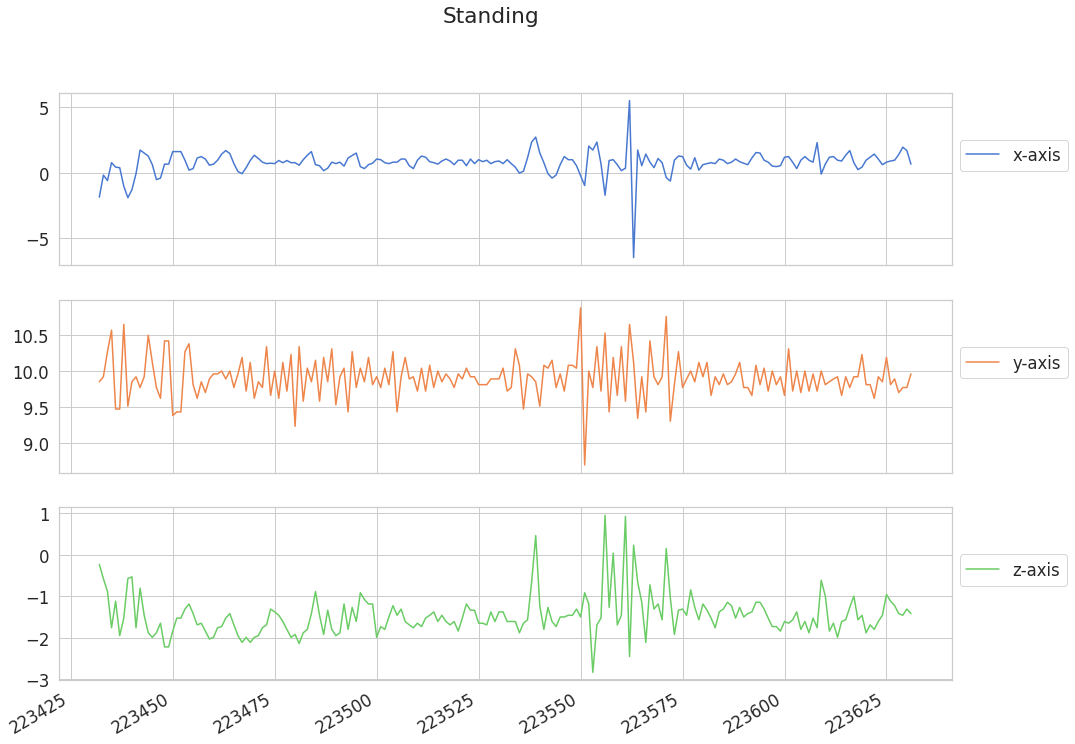

In [13]:
plot_activity("Standing", df)


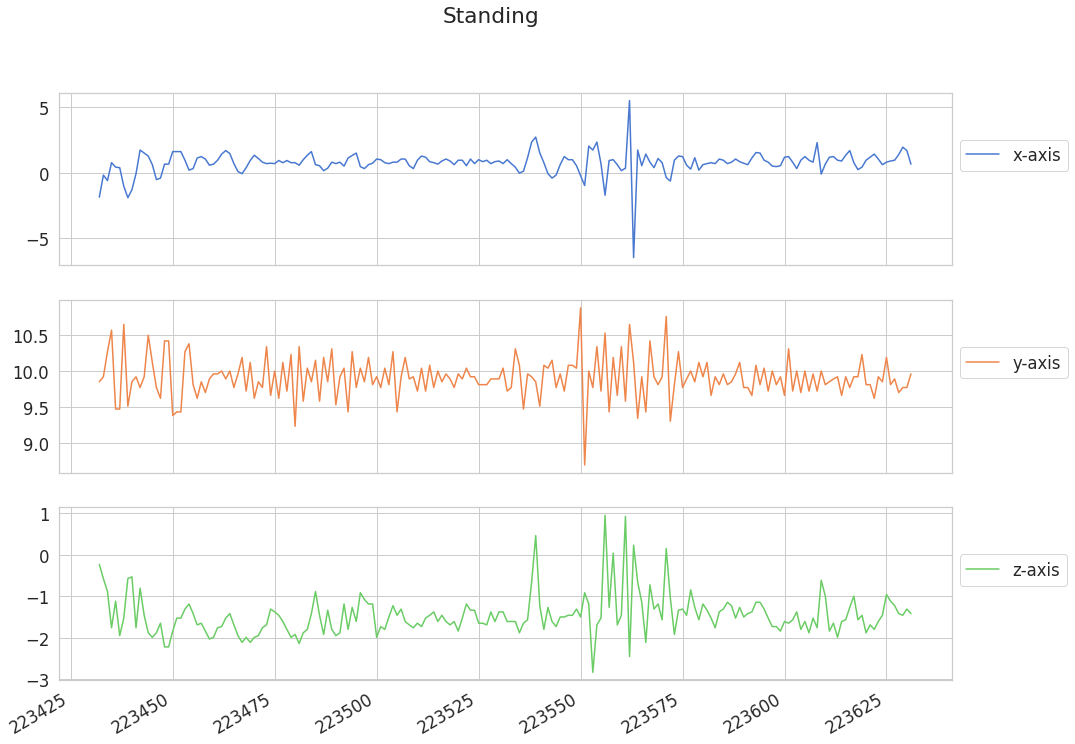

In [14]:
plot_activity("Standing", df)


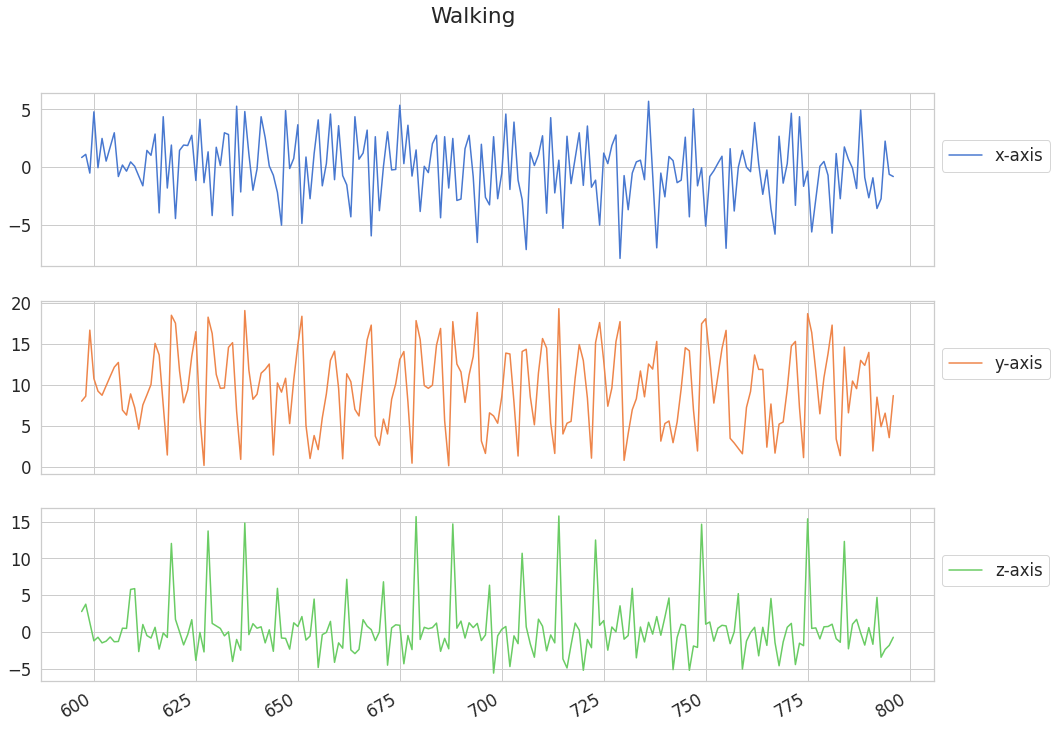

In [15]:
plot_activity("Walking", df)


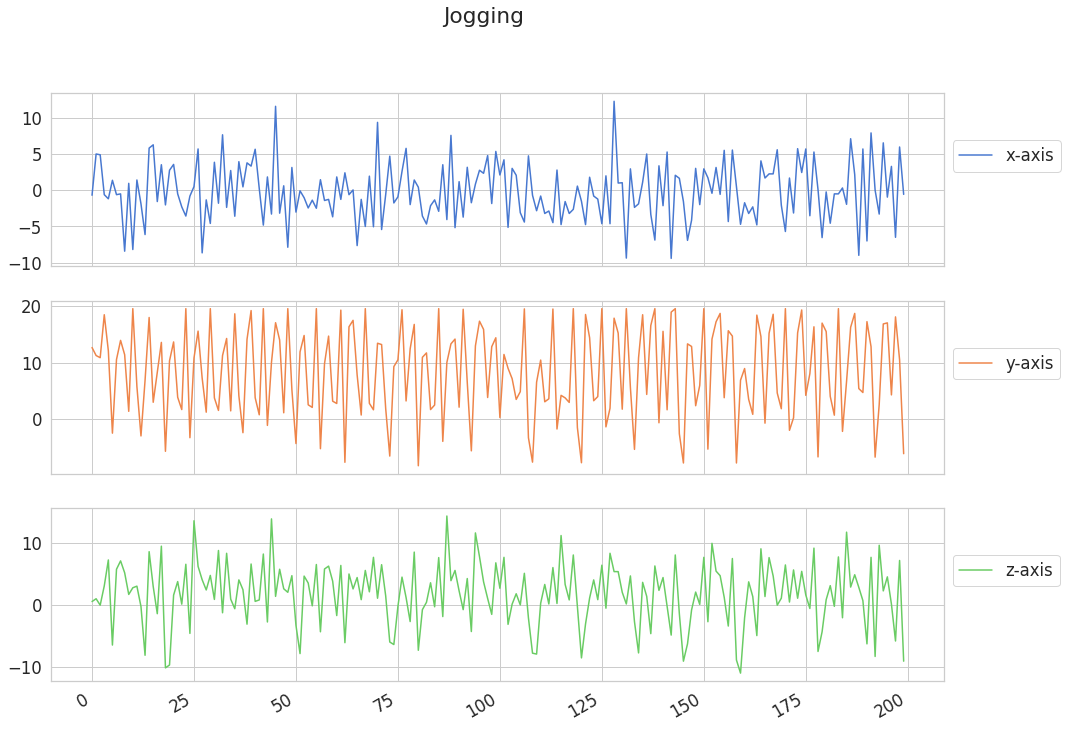

In [16]:
plot_activity("Jogging", df)


In [17]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [18]:
np.array(segments).shape

(54901, 3, 200)

In [19]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [20]:
reshaped_segments.shape


(54901, 200, 3)

In [21]:
labels[0]


array([0., 1., 0., 0., 0., 0.], dtype=float32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
len(X_train)

43920

In [24]:
len(X_test)

10981

In [25]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [26]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [27]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [28]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [30]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [31]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [32]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7992897033691406 loss: 1.3222434520721436
epoch: 10 test accuracy: 0.914488673210144 loss: 0.678021252155304
epoch: 20 test accuracy: 0.9447227120399475 loss: 0.4672027826309204
epoch: 30 test accuracy: 0.9647573232650757 loss: 0.33668482303619385
epoch: 40 test accuracy: 0.9653947949409485 loss: 0.2878262996673584
epoch: 50 test accuracy: 0.9695838093757629 loss: 0.2508734166622162

final results: accuracy: 0.9695838093757629 loss: 0.2508734166622162


In [33]:
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

NotFoundError: ignored

In [34]:
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './content/drive/MyDrive/checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./content/drive/MyDrive/checkpoint/har.ckpt")
sess.close()

NotFoundError: ignored

In [35]:
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './content/drive/MyDrive/checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./content/drive/MyDrive/checkpoint/har.ckpt")
sess.close()

NotFoundError: ignored

In [36]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

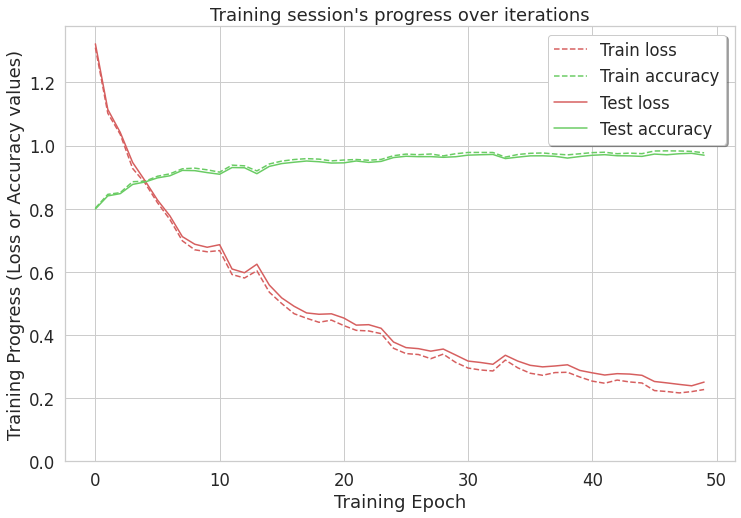

In [37]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [38]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

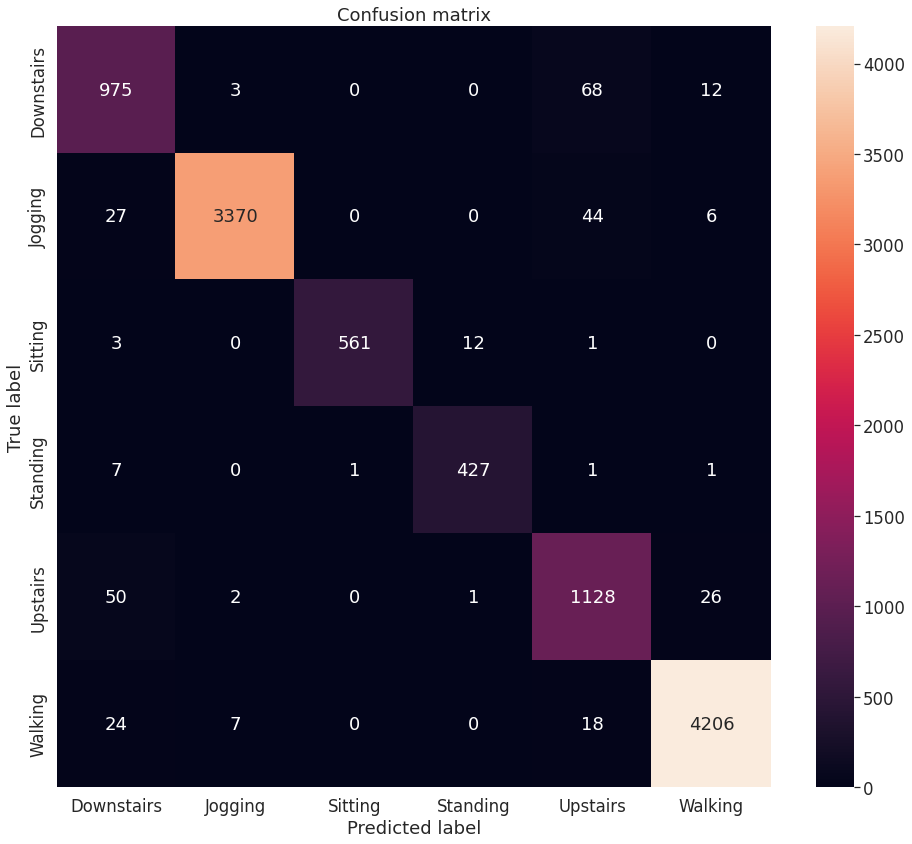

In [39]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();